In [52]:
!pip install pandas
!pip install scikit-learn
!pip install seaborn
!pip install imbalanced-learn



Python(21500) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Defaulting to user installation because normal site-packages is not writeable


Python(21501) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Defaulting to user installation because normal site-packages is not writeable


Python(21502) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Defaulting to user installation because normal site-packages is not writeable


Python(21503) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Defaulting to user installation because normal site-packages is not writeable


In [53]:
import sys
from pathlib import Path

# Set path to the repo root and src folder
repo_root = Path("/Users/ruchitiwari/Desktop/Final CMOR 438/CMOR_438_Final_Repository")
src_path = repo_root / "src"
sys.path.append(str(src_path))

# Import your professor's KNNClassifier from the correct file
from rice_ml.supervised_learning.k_nearest_neighbors import KNNClassifier



In [55]:
import pandas as pd
from pathlib import Path

# Build path to dataset (relative to this notebook)
data_path = Path("../../../Data/adult.csv")

# Load the Adult Income dataset
df = pd.read_csv(data_path)

# Show first rows
df.head()



,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [56]:
# Check the shape (rows, columns)
df.shape

(48842, 15)

In [57]:
# Check column names and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [58]:
import numpy as np

# Replace '?' with NaN
df = df.replace("?", np.nan)

# Check how many missing values we now have
df.isna().sum()


age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

In [59]:
# Drop rows that contain any NaN
df = df.dropna()

# Confirm all missing values are gone
df.isna().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

In [60]:
# ------------------------
# Step 3: Preprocessing for Adult Dataset
# ------------------------

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 1. Replace '?' with NaN and drop missing rows
df = df.replace("?", np.nan)
df = df.dropna()

# 2. Convert target 'income' to binary (<=50K = 0, >50K = 1)
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})

# 3. Identify categorical columns
categorical_cols = [
    'workclass', 'education', 'marital-status', 'occupation',
    'relationship', 'race', 'gender', 'native-country'
]

# 4. One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# 5. Separate features (X) and target (y)
X = df_encoded.drop(columns=['income']).values
y = df_encoded['income'].values

# 6. Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Check shapes
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Training set shape: (36177, 96) (36177,)
Test set shape: (9045, 96) (9045,)


In [61]:
# ------------------------
# Step 4: Train and evaluate KNN on the Adult dataset
# ------------------------

import sys
from pathlib import Path
import warnings
import numpy as np
from sklearn.preprocessing import StandardScaler

# Suppress runtime warnings from distance calculations
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Add src folder to Python path so we can import rice_ml
repo_root = Path().resolve()  # assumes notebook is in repo root
src_path = repo_root / "src"
sys.path.append(str(src_path))

# Import your professor's KNNClassifier
from rice_ml.supervised_learning.k_nearest_neighbors import KNNClassifier

# ------------------- Scale numeric features -------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------- Train KNN -------------------
knn_clf = KNNClassifier(
    n_neighbors=5,
    metric='euclidean',
    weights='uniform'
)

knn_clf.fit(X_train_scaled, y_train)

# ------------------- Predict & Evaluate -------------------
y_pred = knn_clf.predict(X_test_scaled)
accuracy = knn_clf.score(X_test_scaled, y_test)

print(f"KNN accuracy on test set: {accuracy:.4f}")


KNN accuracy on test set: 0.8174


Confusion Matrix:
[[6130  673]
 [ 979 1263]]


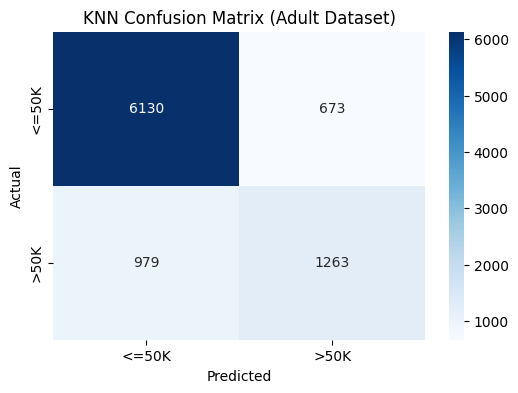


Classification Report:
              precision    recall  f1-score   support

       <=50K       0.86      0.90      0.88      6803
        >50K       0.65      0.56      0.60      2242

    accuracy                           0.82      9045
   macro avg       0.76      0.73      0.74      9045
weighted avg       0.81      0.82      0.81      9045



In [62]:
# ------------------------
# Step 5: Detailed evaluation of KNN predictions (Adult dataset)
# ------------------------

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['<=50K', '>50K'],
            yticklabels=['<=50K', '>50K'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN Confusion Matrix (Adult Dataset)')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred,
                            target_names=['<=50K', '>50K']))



k = 1, accuracy = 0.7811
k = 3, accuracy = 0.8064
k = 5, accuracy = 0.8174
k = 7, accuracy = 0.8201
k = 9, accuracy = 0.8231
k = 11, accuracy = 0.8258
k = 15, accuracy = 0.8228
k = 21, accuracy = 0.8224


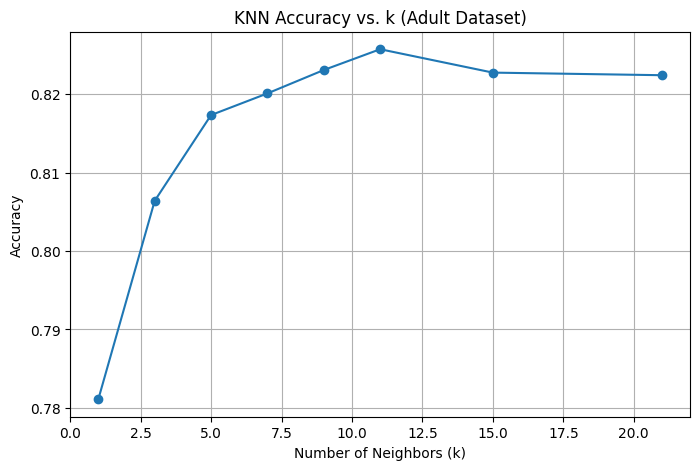

In [63]:
# ------------------------
# Step 6: Evaluate KNN performance for different values of k
# ------------------------

from rice_ml.supervised_learning.k_nearest_neighbors import KNNClassifier

k_values = [1, 3, 5, 7, 9, 11, 15, 21]
accuracies = []

for k in k_values:
    clf = KNNClassifier(n_neighbors=k, metric='euclidean', weights='uniform')
    clf.fit(X_train_scaled, y_train)
    acc = clf.score(X_test_scaled, y_test)
    accuracies.append(acc)
    print(f"k = {k}, accuracy = {acc:.4f}")

# Plot accuracies
plt.figure(figsize=(8,5))
plt.plot(k_values, accuracies, marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy vs. k (Adult Dataset)")
plt.grid(True)
plt.show()



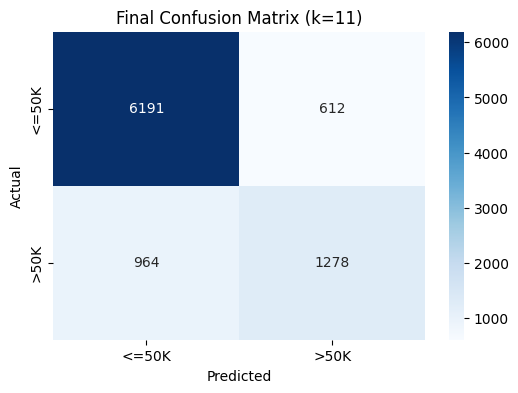


Final Classification Report:
              precision    recall  f1-score   support

       <=50K       0.87      0.91      0.89      6803
        >50K       0.68      0.57      0.62      2242

    accuracy                           0.83      9045
   macro avg       0.77      0.74      0.75      9045
weighted avg       0.82      0.83      0.82      9045



In [64]:
# ------------------------
# Step 7: Final model evaluation with best k
# ------------------------

best_k = 11  # <-- update this after Step 6 results

final_clf = KNNClassifier(n_neighbors=best_k, metric='euclidean', weights='uniform')
final_clf.fit(X_train_scaled, y_train)

final_pred = final_clf.predict(X_test_scaled)

cm_final = confusion_matrix(y_test, final_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues',
            xticklabels=['<=50K', '>50K'],
            yticklabels=['<=50K', '>50K'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Final Confusion Matrix (k={best_k})')
plt.show()

print("\nFinal Classification Report:")
print(classification_report(y_test, final_pred,
                            target_names=['<=50K', '>50K']))

